In [18]:
import numpy as np
import gensim
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, Flatten, merge, SimpleRNN, TimeDistributed
from keras.optimizers import Adam
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle

In [2]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))

Number of words in corpora: 26


In [3]:
tmp = list(corpora.items())

In [4]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [6]:
cs=2

In [7]:
c_in_dat = [[text[i+n] for i in range(0, len(text)-1-cs, cs)]
            for n in range(cs)]

In [8]:
xs = [np.stack(c[:-2]) for c in c_in_dat]

In [9]:
c_out_dat = [[text[i+n] for i in range(1, len(text)-cs, cs)]
            for n in range(cs)]

In [10]:
ys = [np.stack(c[:-2]) for c in c_out_dat]

In [11]:
[xs[n][:cs] for n in range(cs)]

[array([2, 4]), array([0, 8])]

In [12]:
[ys[n][:cs] for n in range(cs)]

[array([0, 8]), array([4, 3])]

### Create and train model

In [16]:
n_fac = 4
n_hidden = 256

In [19]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_3 (Embedding)          (None, 2, 4)          104         embedding_input_1[0][0]          
____________________________________________________________________________________________________
simplernn_2 (SimpleRNN)          (None, 2, 256)        66816       embedding_3[0][0]                
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribute(None, 2, 26)         6682        simplernn_2[0][0]                
Total params: 73602
____________________________________________________________________________________________________


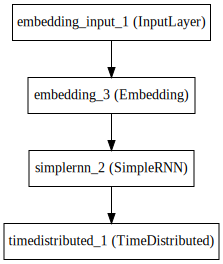

In [22]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
xs[0].shape

(12,)

In [24]:
x_rnn=np.stack(xs, axis=1)
y_rnn=np.expand_dims(np.stack(ys, axis=1), -1)

In [25]:
x_rnn.shape, y_rnn.shape

((12, 2), (12, 2, 1))

In [27]:
model.fit(x_rnn, y_rnn, batch_size=1, nb_epoch=100)

Epoch 1/100
12/12 [==============================] - 0s - loss: 3.2077     
Epoch 2/100
12/12 [==============================] - 0s - loss: 3.1526     
Epoch 3/100
12/12 [==============================] - 0s - loss: 3.0739     
Epoch 4/100
12/12 [==============================] - 0s - loss: 2.9628     
Epoch 5/100
12/12 [==============================] - 0s - loss: 2.8376     
Epoch 6/100
12/12 [==============================] - 0s - loss: 2.7038     
Epoch 7/100
12/12 [==============================] - 0s - loss: 2.5798     
Epoch 8/100
12/12 [==============================] - 0s - loss: 2.4449     
Epoch 9/100
12/12 [==============================] - 0s - loss: 2.3160     
Epoch 10/100
12/12 [==============================] - 0s - loss: 2.1775     
Epoch 11/100
12/12 [==============================] - 0s - loss: 2.0667     
Epoch 12/100
12/12 [==============================] - 0s - loss: 1.9257     
Epoch 13/100
12/12 [==============================] - 0s - loss: 1.8318     
Epoch 14

In [31]:
model.save('./models/dev_fast_ai_returning_sequences_keras.h5')

In [32]:
def get_nexts_keras(inp):
    idxs = [corpora.token2id[c] for c in inp]
    arr = np.array(idxs)[np.newaxis,:]
    p = model.predict(arr)[0]
    #print(list(inp))
    return [corpora.id2token[np.argmax(o)] for o in p]

In [33]:
get_nexts_keras(['three', 'four'])

['four', 'five']